## DIAGNOSTIC PLOTS

TODO: 

- Note that K25_PRM is worse than K01_PRM in terms of inflow angle!
- Do the supplementary figures (KXX_FIT and KXX_wIA).

Make sure the filters match.

For KXX_PRM models, I use the raw database based on the common filters (472 cases). For the KXX_FIT and KXX_wIA models, I use the cleaned databases (~100 cases). Maybe change that later. Maybe merge the analyze cases onto the cleaned database. In any case, I will have to do this for the wIA models issued from the list_of_collocated_paths list.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir':     '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/03_DIAGNOSE_PLOTS/',
    'sct_dir':     '/home/arthur/data/tropical_cyclones/scatterometer/hy-2/',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/cases/',
    'K01_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/cases/',
    'K25_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/cases/',
    'K25_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/cases/',
    'K25_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/cases/',
}

PRMS = {
    'dt': 90, # Delta time used for SAR/SCT collocation, in min
    'sav_fgs': False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Fetch all PRM files
list_of_PRM_paths = glob.glob(PTHS['K01_PRM_dir'] + '*.nc')

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 10) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &
    (dsg.dist2coast  > dsg.r34)              # Distance to coast
    # ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shear
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

472


In [4]:
# ### OLD

# # FILTERS
# cond = (
#     (dsg.center_quality_flag < 2) & 
#     (dsg.percent_outside < 50) & 
#     (dsg.percent_rmx_inside == 1) &
#     (abs(dsg.lat) < 30) & 
#     (dsg.rmx < 100000) & 
#     (dsg.vmx > 20)
# )
# dsg_filtered    = dsg.where(cond, drop=True)
# print(len(dsg_filtered.time))

In [5]:
# # FILTERS
# cond = (
#     # (dsg.lat > 0) &             # Northern hemisphere; Remove this filter?
#     (dsg.dist2coast  > dsg.r34) & # Distance to coast
#     (dsg.percent_outside < 10)  & # Sufficient SAR coverage
#     (dsg.vmx > 20)    
# )
# dsg_filtered    = dsg.where(cond, drop=True)
# print(len(dsg_filtered.time))

In [6]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 0) Fitting diagnostic and datasets filtering

The retained filters are:

In [7]:
# dk01 = dkg01.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
#     (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
#     (dkg01.vmx > 20)                            & # Test
#     (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
#     (dkg01.C_K01 != 0.1)                        &  # Reached the upper bound
#     (dkg01.asym_avg_err  <= 3)                     # Asymmetry is fitted
#     # (~xr.where(dkg01.non_C1 == 0, False, True))  # Ensure that I > V/r
# )

# abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5

With the subtility that dkg01.asym_avg_err <= 3 for K01 and dkg.asym_avg_err  <= 2 for K25 (explainable because the K01 asymmetries are less consistent with SAR than the K25 ones). Also, the non-C1 filter can be a posteriori highlighted on the plots. 

Lastly, we have to include the additional filter: abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5 and same for K25, to make sure that I don't have any fitting issue (where dk01 is with fixed_K = 50 and dk012 is with fixed_K = 100).

#### a) K01_FIT

In [8]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto50.nc'
dkg01 = xr.open_dataset(p)
dk01  = dkg01.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
    (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01.vmx > 20)                            & # Test
    (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01.asym_avg_err  <= 3)                    # Asymmetry is fitted
    # (~xr.where(dkg01.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01.phase_avg_err <= 45)                 &           # Test
    # ((dkg01.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01.time))
print(len(dk01.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
306


In [9]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto100.nc'
dkg01_withKsetto100 = xr.open_dataset(p)
dk01_withKsetto100  = dkg01_withKsetto100.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
    (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto100.vmx > 20)                                          & # Test
    (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto100.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar <2)) # Test
    # (dkg01_withKsetto100.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto100.time))
print(len(dkg01_withKsetto100.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


In [10]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto10.nc'
dkg01_withKsetto10 = xr.open_dataset(p)
dk01_withKsetto10  = dkg01_withKsetto10.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
    (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto10.vmx > 20)                                          & # Test
    (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar <2)) # Test
    # (dkg01_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto10.time))
print(len(dkg01_withKsetto10.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

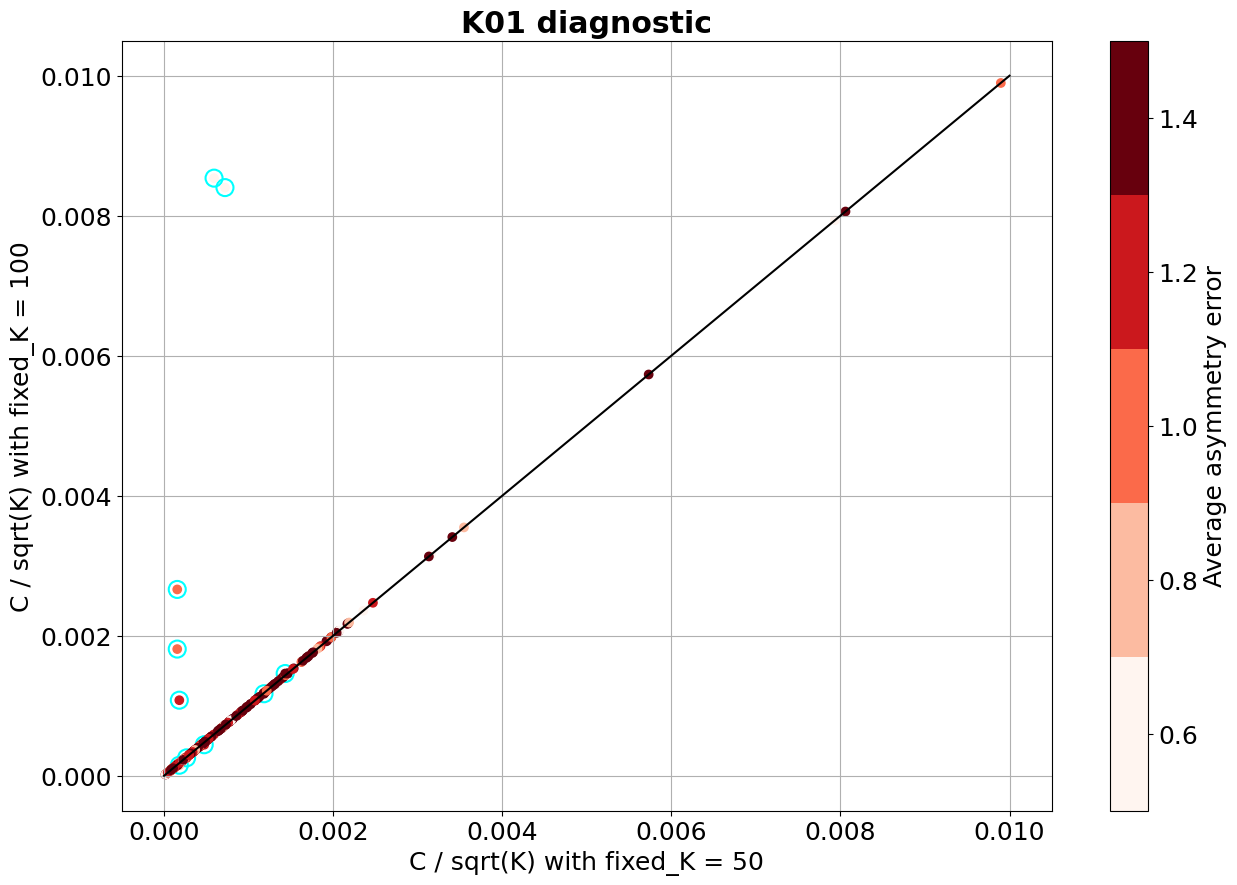

In [11]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_upper = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_upper).C_sqrtK_K01, dk01_withKsetto100.where(msk_k01_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto100.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

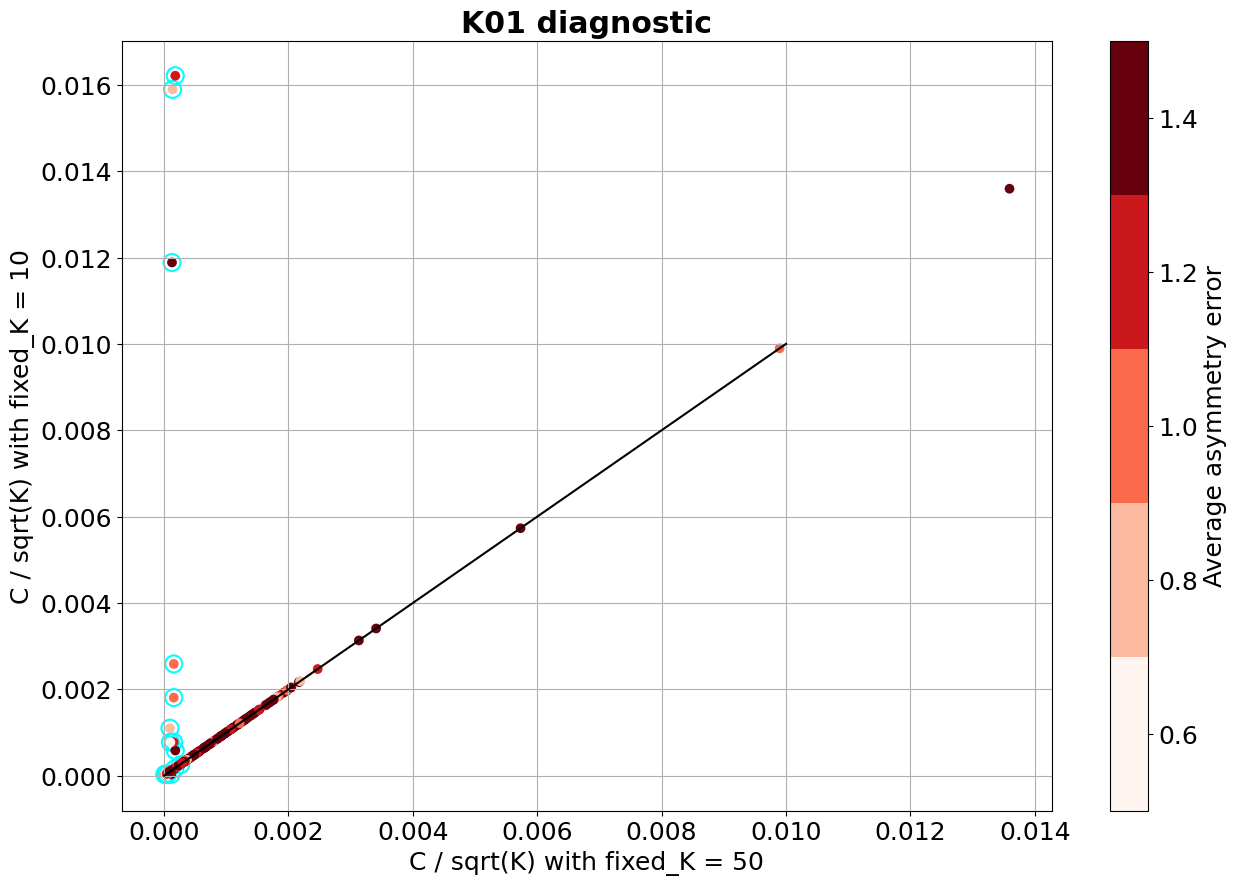

In [12]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_lower = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_lower).C_sqrtK_K01, dk01_withKsetto10.where(msk_k01_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto10.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

For ~30-50 cases, the fitting bounds for C are reached (see commented cell below). They correspond to complicated cases.

In [13]:
# a  = dkg01_withKsetto10.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
#     (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01_withKsetto100.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
#     (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### b) K25_FIT

In [14]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dkg25 = xr.open_dataset(p)
dk25  = dkg25.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25.dist2coast  > dkg25.r34)             & # Distance to coast
    (dkg25.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25.vmx > 20)                            & # Test
    (dkg25.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25.asym_avg_err  <= 2)                    # Asymmetry is fitted
    # (~xr.where(dkg25.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25.phase_avg_err <= 45)                           & # Test
    # (dkg25.C_sqrtK_K25 > 1.5e-5)                          & # Test: Reached the lower bound
    # (dkg25.C_sqrtK_K25 < 1.41e-3)                         & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25.time))
print(len(dk25.dropna(dim='time', subset=['vmx']).time))

472
362


In [15]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto100.nc'
dkg25_withKsetto100 = xr.open_dataset(p)
dk25_withKsetto100  = dkg25_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
    (dkg25_withKsetto100.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_withKsetto100.vmx > 20)                          & # Test
    (dkg25_withKsetto100.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg25_withKsetto100.C_K25 != 0.1)                      & # Reached the upper bound
    (dkg25_withKsetto100.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto100.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25_withKsetto100.phase_avg_err <= 45)                                         & # Test
    # (dkg25_withKsetto100.C_sqrtK_K25 > 1.5e-5)                                        & # Test: Reached the lower bound
    # (dkg25_withKsetto100.C_sqrtK_K25 < 1.41e-3)                                       & # Test: Reached the upper bound    
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_withKsetto100.time))
print(len(dk25_withKsetto100.dropna(dim='time', subset=['vmx']).time))

472
373


In [16]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto10.nc'
dkg25_withKsetto10 = xr.open_dataset(p)
dk25_withKsetto10  = dkg25_withKsetto10.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)              & # Distance to coast
    (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg25_withKsetto10.vmx > 20)                                          & # Test
    (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
    (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
    (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg25_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar <2)) # Test
    # (dkg25_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25_withKsetto10.time))
print(len(dkg25_withKsetto10.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

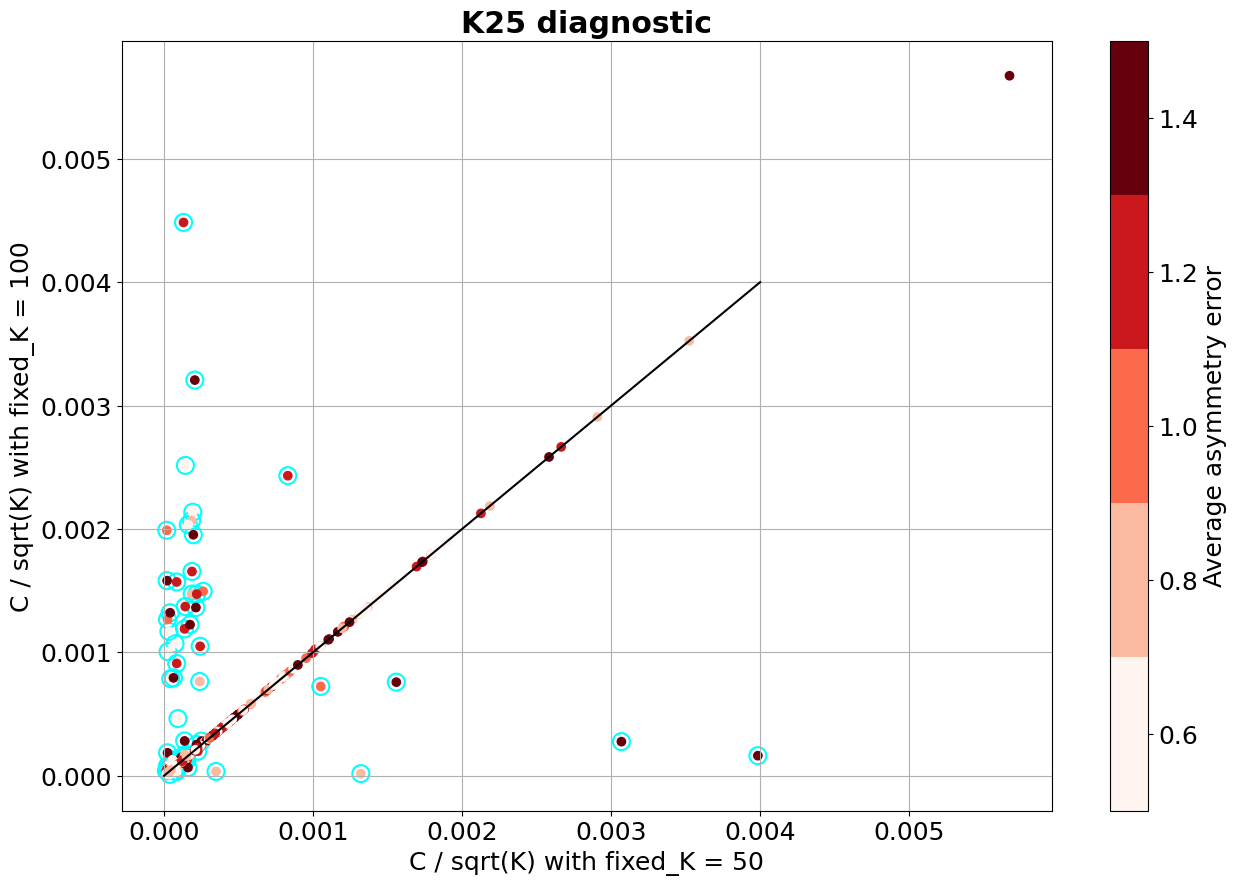

In [17]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_upper = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_upper).C_sqrtK_K25, dk25_withKsetto100.where(msk_k25_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto100.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

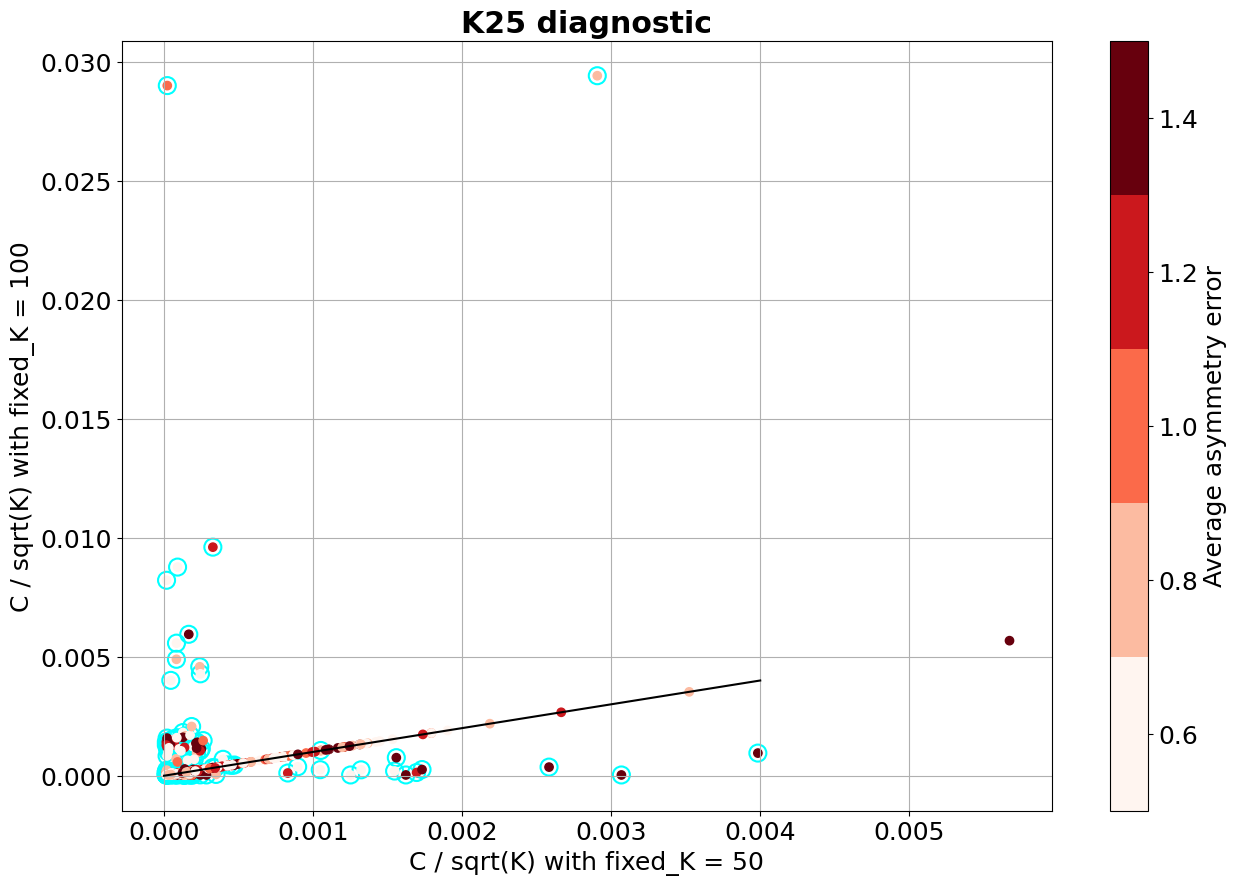

In [18]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_lower = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_lower).C_sqrtK_K25, dk25_withKsetto10.where(msk_k25_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto10.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

The fitting bounds for C are not reached (see commented cell below).

In [19]:
# a  = dkg25_withKsetto10.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
#     (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25_withKsetto100.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
#     (dkg25_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto100.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto100.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### c) K25_semiFit

In [20]:
### K25 SemiFit
p             = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/dsg_K25_semiFit.nc'
dkg25_semiFit = xr.open_dataset(p)
dk25_semiFit  = dkg25_semiFit.where(
    # (dkg25_semiFit.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_semiFit.dist2coast  > dkg25_semiFit.r34)     & # Distance to coast
    (dkg25_semiFit.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_semiFit.vmx > 20)                          & # Test
    (dkg25_semiFit.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_semiFit.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # (dkg25_semiFit.phase_avg_err <= 45)               & # Test
    # (dkg25_semiFit.C_sqrtK_K25 > 1.5e-5)              & # Test: Reached the lower bound
    # (dkg25_semiFit.C_sqrtK_K25 < 1.41e-3)             & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_semiFit.time))
print(len(dk25_semiFit.dropna(dim='time', subset=['vmx']).time))

472
410


#### d) K01_wIA

In [21]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto50.nc'
dkg01i = xr.open_dataset(p)
dk01i  = dkg01i.where(
    # (dkg01.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg01i.dist2coast  > dkg01i.r34)            & # Distance to coast
    (dkg01i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01i.vmx > 20)                            & # Test
    (dkg01i.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01i.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg01i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg01i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01i.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01i.phase_avg_err <= 45)                 &           # Test
    # ((dkg01i.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i.time))
print(len(dk01i.dropna(dim='time', subset=['vmx']).time))

354
243


In [22]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto100.nc'
dkg01i_withKsetto100 = xr.open_dataset(p)
dk01i_withKsetto100  = dkg01i_withKsetto100.where(
    # (dkg01_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)             & # Distance to coast
    (dkg01i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto100.vmx > 20)                                           & # Test
    (dkg01i_withKsetto100.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto100.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg01i_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto100.time))
print(len(dk01i_withKsetto100.dropna(dim='time', subset=['vmx']).time))

354
245


In [23]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto10.nc'
dkg01i_withKsetto10 = xr.open_dataset(p)
dk01i_withKsetto10  = dkg01i_withKsetto10.where(
    # (dkg01_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)              & # Distance to coast
    (dkg01i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto10.vmx > 20)                                           & # Test
    (dkg01i_withKsetto10.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto10.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01i_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto10.time))
print(len(dk01i_withKsetto10.dropna(dim='time', subset=['vmx']).time))

354
241


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

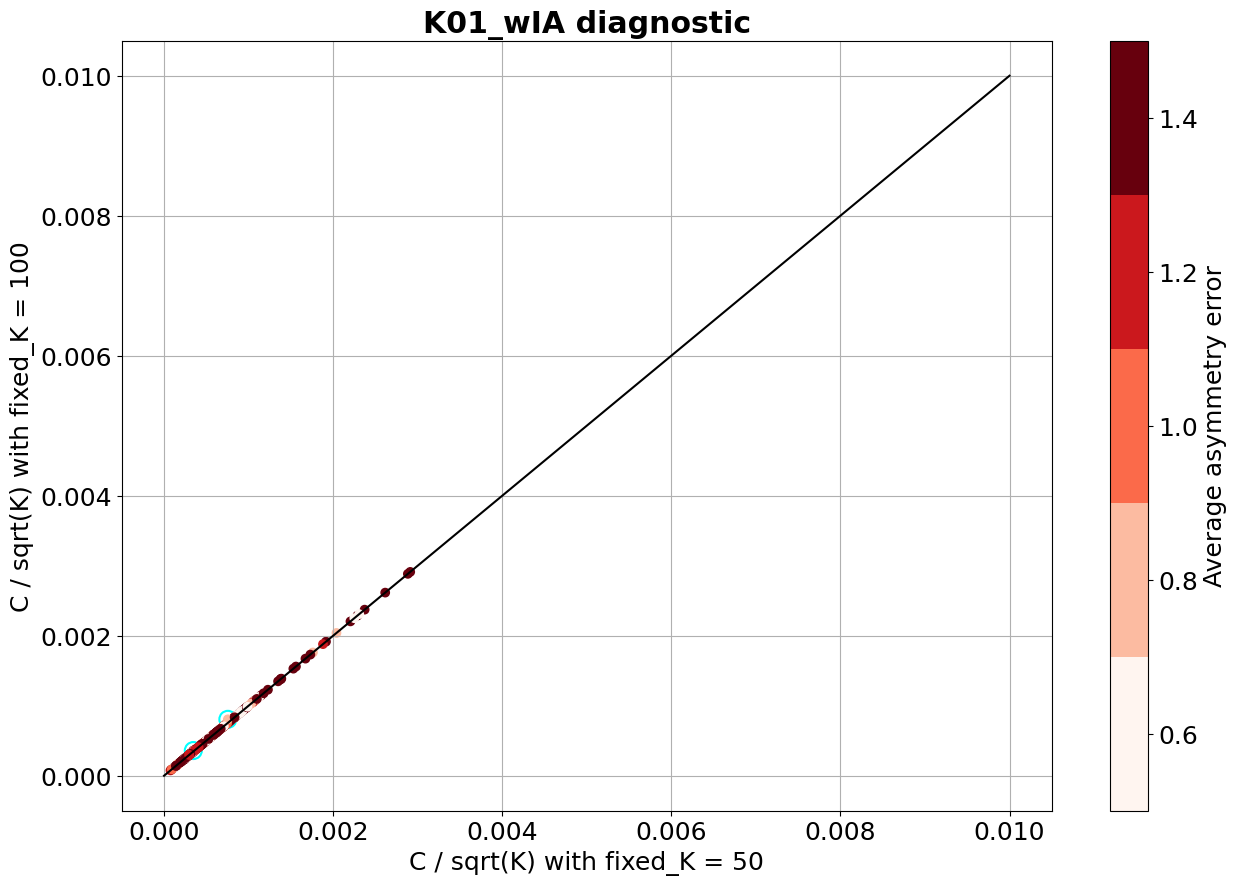

In [24]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_upper = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_upper).C_sqrtK_K01, dk01i_withKsetto100.where(msk_k01i_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto100.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

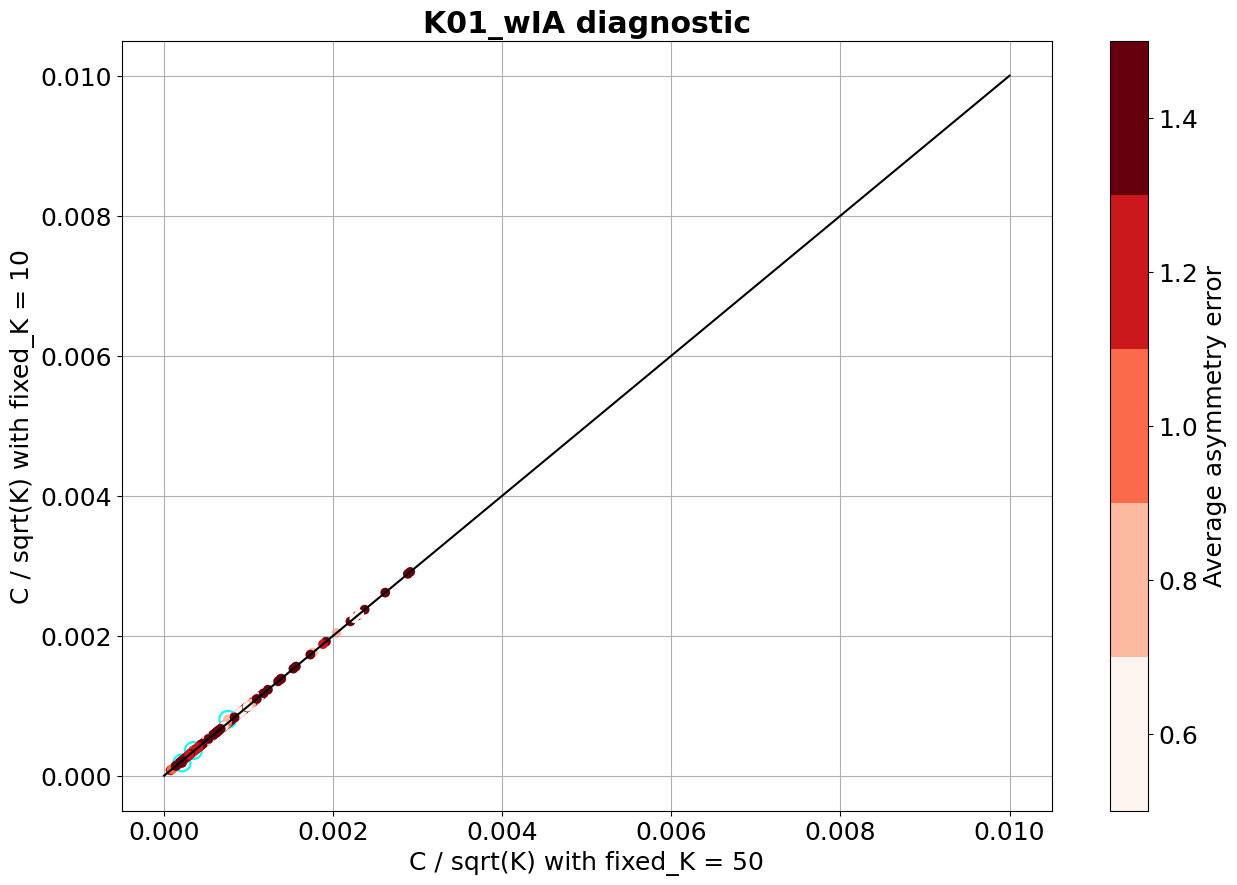

In [25]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_lower = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_lower).C_sqrtK_K01, dk01i_withKsetto10.where(msk_k01i_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto10.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 2 cases (see commented cell below).

In [26]:
# a  = dkg01i_withKsetto10.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)             & # Distance to coast
#     (dkg01i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto10.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto10.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01i_withKsetto100.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)            & # Distance to coast
#     (dkg01i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto100.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto100.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### e) K25_wIA

In [27]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto50.nc'
dkg25i = xr.open_dataset(p)
dk25i  = dkg25i.where(
    # (dkg25.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg25i.dist2coast  > dkg25i.r34)            & # Distance to coast
    (dkg25i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25i.vmx > 20)                            & # Test
    (dkg25i.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25i.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg25i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg25i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg25i.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25i.phase_avg_err <= 45)                 &           # Test
    # ((dkg25i.storm_speed_ibt / dkg25.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i.time))
print(len(dk25i.dropna(dim='time', subset=['vmx']).time))

354
263


In [28]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto100.nc'
dkg25i_withKsetto100 = xr.open_dataset(p)
dk25i_withKsetto100  = dkg25i_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)             & # Distance to coast
    (dkg25i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto100.vmx > 20)                                           & # Test
    (dkg25i_withKsetto100.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto100.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg25i_withKsetto100.storm_speed_ibt / dkg25_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto100.time))
print(len(dk25i_withKsetto100.dropna(dim='time', subset=['vmx']).time))

354
264


In [29]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto10.nc'
dkg25i_withKsetto10 = xr.open_dataset(p)
dk25i_withKsetto10  = dkg25i_withKsetto10.where(
    # (dkg25_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)              & # Distance to coast
    (dkg25i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto10.vmx > 20)                                           & # Test
    (dkg25i_withKsetto10.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto10.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25i_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto10.time))
print(len(dk25i_withKsetto10.dropna(dim='time', subset=['vmx']).time))

354
260


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

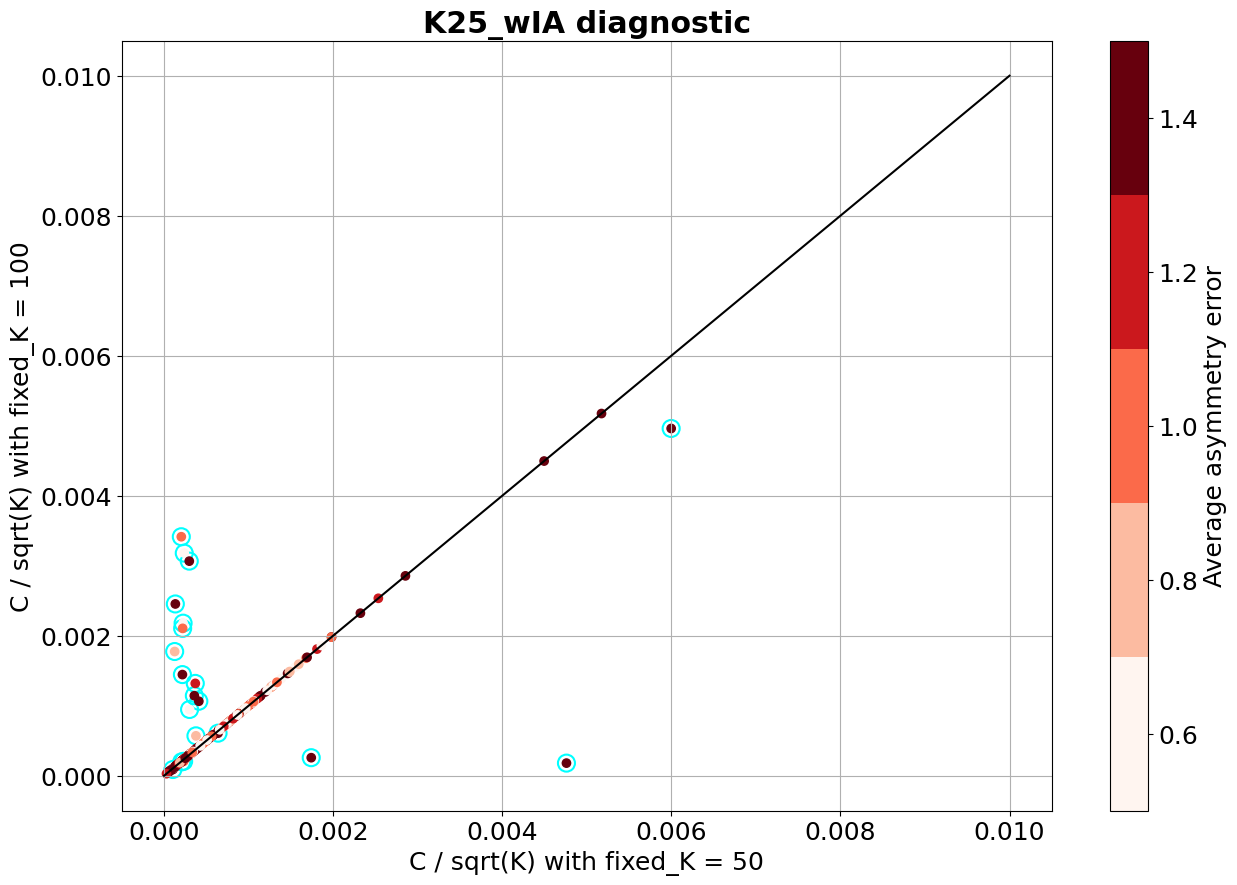

In [30]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_upper = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_upper).C_sqrtK_K25, dk25i_withKsetto100.where(msk_k25i_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto100.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

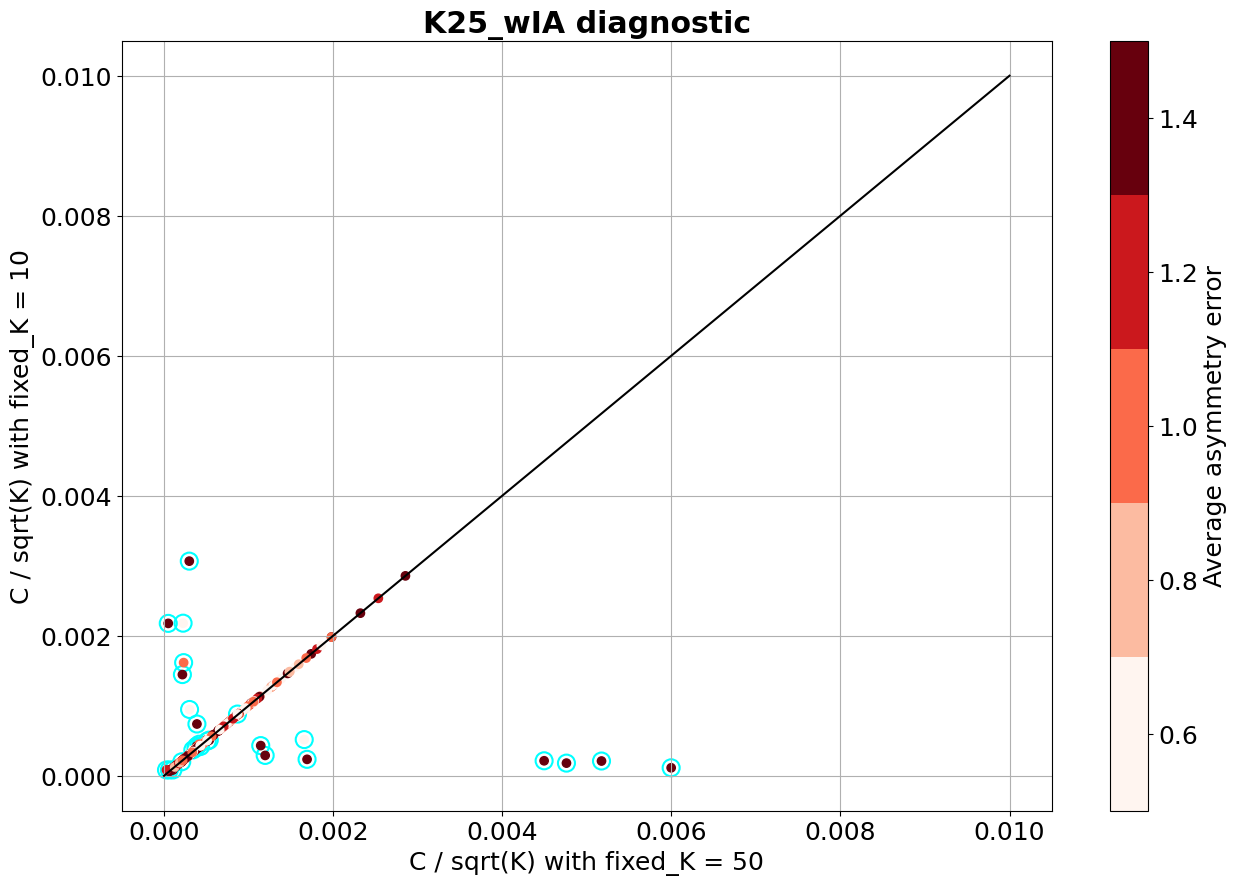

In [31]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_lower = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_lower).C_sqrtK_K25, dk25i_withKsetto10.where(msk_k25i_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto10.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 1 case (see commented cell below).

In [32]:
# a  = dkg25i_withKsetto10.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)             & # Distance to coast
#     (dkg25i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto10.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto10.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25i_withKsetto100.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)            & # Distance to coast
#     (dkg25i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto100.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto100.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### f) Clean the datasets

In [33]:
### FILTER BOTH DATASETS
# TO ENSURE THAT FIXED_K HAS NO IMPACT
dk01_clean  = dk01.where(~msk_k01_upper & ~msk_k01_lower)
dk25_clean  = dk25.where(~msk_k25_upper & ~msk_k25_lower)
dk01i_clean = dk01i.where(~msk_k01i_upper & ~msk_k01i_lower)
dk25i_clean = dk25i.where(~msk_k25i_upper & ~msk_k25i_lower)

# # TO DROP DUPLICATES FOR MULTIPLE SCAT COLLOCATIONS
# dk01i_clean = dk01i_clean.where(~dk01i_clean.indexes['time'].duplicated()).dropna(dim='time')
# dk25i_clean = dk25i_clean.where(~dk25i_clean.indexes['time'].duplicated()).dropna(dim='time')
dk01i_clean =  dk01i_clean.drop_duplicates(dim='time', keep='first')
dk25i_clean =  dk25i_clean.drop_duplicates(dim='time', keep='first')

### 1) Diagnose winds

We first extract necessary wind speeds and inflow angles.

Let us start with the wind speeds.

In [34]:
### Define r_star
r_star = np.linspace(0, 16, 16 * 8 + 1)
# rs            = np.linspace(1000, 5e5, 500)

In [35]:
### Extract SAR and KXX_PRM wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfWspds_dsp       = [] # SAR
# K01 param
listOfWspds_dsk01_prm = [] # K01 param
wspd_diffs_k01p       = [] # Wind speed diffs,                       
wspd_res_k01p         = [] # Wind speed relative errors
wspd_diffs_k01p_      = [] # Wind speed diffs, interp. on r_star                      
wspd_res_k01p_        = [] # Wind speed relative errors, interp. on r_star 
# K25 param
listOfWspds_dsk25_prm = [] # K25 param
wspd_diffs_k25p       = [] # Wind speed diffs,                       
wspd_res_k25p         = [] # Wind speed relative errors
wspd_diffs_k25p_      = [] # Wind speed diffs, interp. on r_star                       
wspd_res_k25p_        = [] # Wind speed relative errors, interp. on r_star

for path in tqdm(list_of_PRM_paths):
    dsk01_prm         = xr.open_dataset(PTHS['K01_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    dsk25_prm         = xr.open_dataset(PTHS['K25_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_prm.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk01_prm.file_tcva.item()).isel(time=0)

    # Add the non-interpolated wind speeds
    wspd_diff_k01p    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk01_prm.wind_speed))
    wspd_re_k01p      = np.divide(wspd_diff_k01p, np.array(dsp.wind_speed.transpose()))
    wspd_diff_k25p    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk25_prm.wind_speed))
    wspd_re_k25p      = np.divide(wspd_diff_k25p, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk01p, dk25p = dsp.copy(deep=True), dsk01_prm.copy(deep=True), dsk25_prm.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01p['rad']      = dk01p['rad'] / float(ds.rmx)
    dk25p['rad']      = dk25p['rad'] / float(ds.rmx)
    wspd_diff_k01p_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk01p.wind_speed.interp(rad=r_star)))
    wspd_re_k01p_     = np.divide(wspd_diff_k01p_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    wspd_diff_k25p_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk25p.wind_speed.interp(rad=r_star)))
    wspd_re_k25p_     = np.divide(wspd_diff_k25p_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))

    ### Append
    # SAR
    listOfWspds_dsp.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K01 param
    listOfWspds_dsk01_prm.append(np.array(dsk01_prm.wind_speed).flatten())
    wspd_diffs_k01p.append(wspd_diff_k01p)
    wspd_res_k01p.append(wspd_re_k01p)
    wspd_diffs_k01p_.append(wspd_diff_k01p_)
    wspd_res_k01p_.append(wspd_re_k01p_)
    # K25 param
    listOfWspds_dsk25_prm.append(np.array(dsk25_prm.wind_speed).flatten())
    wspd_diffs_k25p.append(wspd_diff_k25p)
    wspd_res_k25p.append(wspd_re_k25p)
    wspd_diffs_k25p_.append(wspd_diff_k25p_)
    wspd_res_k25p_.append(wspd_re_k25p_)

    # Close
    dsp.close()
    dsk01_prm.close()
    dsk25_prm.close()
    dss.close()
    dk01p.close()
    dk25p.close()

  0%|          | 0/472 [00:00<?, ?it/s]

In [36]:
### Concatenate the raw wind speeds
wspds_dsp           = np.concatenate(listOfWspds_dsp)
wspds_dsk01_prm     = np.concatenate(listOfWspds_dsk01_prm)
wspds_dsk25_prm     = np.concatenate(listOfWspds_dsk25_prm)

### Concatenate the r_star wind speeds
arr_spd_diffs_k01p_ = np.concatenate(wspd_diffs_k01p_)
arr_spd_diffs_k25p_ = np.concatenate(wspd_diffs_k25p_)

We then extract the inflow angles.

In [37]:
### Open inflow angles
# (about 30 seconds)

# For debug, use t = 90

# Initialize
list_of_collocated_sct_pths = []
list_of_collocated_sar_fles = []

# Iterate
for t in tqdm(range(len(dsg_filtered.time))):
    ### Open SAR
    ds         = dsg_filtered.isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths.append(matching_path)
            list_of_collocated_sar_fles.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()
    ### Open models
    # dsp        = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    # dsk_prm    = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10, theta=slice(0, 359))
    # dsk_fit    = xr.open_dataset(PTHS['K01_FIT_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10).interp(theta=np.array(dsp.theta))

print(len(list_of_collocated_sct_pths))

  0%|          | 0/472 [00:00<?, ?it/s]

354


In [38]:
# Check for duplicates
has_duplicates = len(list_of_collocated_sar_fles) != len(set(list_of_collocated_sar_fles))
if has_duplicates:
    print("La liste contient des doublons.")
else:
    print("La liste ne contient pas de doublons.")

La liste contient des doublons.


In [39]:
### Open data
# (about 1 minute)

# SCAT
dsc_sct = xr.open_mfdataset(list_of_collocated_sct_pths, combine='nested', concat_dim='idx')
# K01 PRM
dsk01p  = xr.open_mfdataset([PTHS['K01_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# # K01 FIT
# dsk01f  = xr.open_mfdataset([PTHS['K01_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 PRM
dsk25p  = xr.open_mfdataset([PTHS['K25_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# # K25 FIT
# dsk25f  = xr.open_mfdataset([PTHS['K25_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

# ### Optional
# # K01 wIA
# dsk01i  = xr.open_mfdataset([PTHS['K01_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# # K25 wIA
# dsk25i  = xr.open_mfdataset([PTHS['K25_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

In [40]:
### Flatten raw inflow angles
ias_sct  = np.array(dsc_sct.inflow_angle).flatten()
ias_k01p = np.array(dsk01p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle).flatten()
ias_k25p = np.array(dsk25p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle).flatten()

In [41]:
### Interpolate inflow angles on r_star
# (about 1 minute)

### Initialize
# K01 param
ias_diffs_k01p_ = [] # K01 param
# K25 param
ias_diffs_k25p_ = [] # K25 param

# K01 PRM
for i in tqdm(range(len(dsk01p.idx))):
    file_tcva    = dsk01p.isel(idx=i).file_tcva
    # ds           = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_prm.file_tcva.item(), drop=True).isel(time=0)
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk01p   = dsc_sct.isel(idx=i).copy(deep=True), dsk01p.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk01p['rad'] = dk01p['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk01p.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k01p_.append(diff)
    # Close
    dss.close()
    dk01p.close()

# K25 PRM
for i in tqdm(range(len(dsk25p.idx))):
    file_tcva    = dsk25p.isel(idx=i).file_tcva
    # ds           = dsg_filtered.where(dsg_filtered.file_tcva == dsk25_prm.file_tcva.item(), drop=True).isel(time=0)
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk25p   = dsc_sct.isel(idx=i).copy(deep=True), dsk25p.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk25p['rad'] = dk25p['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk25p.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k25p_.append(diff)
    # Close
    dss.close()
    dk25p.close()

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

In [42]:
### Concatenate the r_star inflow angles
arr_ia_diffs_k01p_ = np.concatenate(ias_diffs_k01p_)
arr_ia_diffs_k25p_ = np.concatenate(ias_diffs_k25p_)

In [43]:
# abs(dsk01p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle - dsc_sct.inflow_angle).mean(dim=['theta', 'idx']).plot(c='r')
# abs(dsk25p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle - dsc_sct.inflow_angle).mean(dim=['theta', 'idx']).plot(c='b')

In [44]:
# plt.hist(ias_k01p)
# plt.hist(ias_k25p, color='r')

Then choose the colors

In [45]:
# --- Création de la colormap personnalisée ---
colors = ["white",
          "saddlebrown",
          "lightgoldenrodyellow",
          "lightgreen",
          "darkgreen",
          "darkblue"]

nodes = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

In [46]:
### Choose colors
# c_sar = '#1E5631'  # Dark Green
c_sar = 'darkgreen'
c_k01 = '#D62728'  # Brick Red
# c_k25 = '#1F77B4'  # Muted Blue
c_k25 = 'gold'
# c_sct = '#FF7F0E'  # Safety Orange
c_sct = 'sienna'
c_hol = '#9467BD'  # Deep Purple
# c_tbl = '#17BECF'   # Dark Cyan
# c_tbl = 'gold'
c_tbl = '#1F77B4'  # Muted Blue

#### a) KXX_PRM

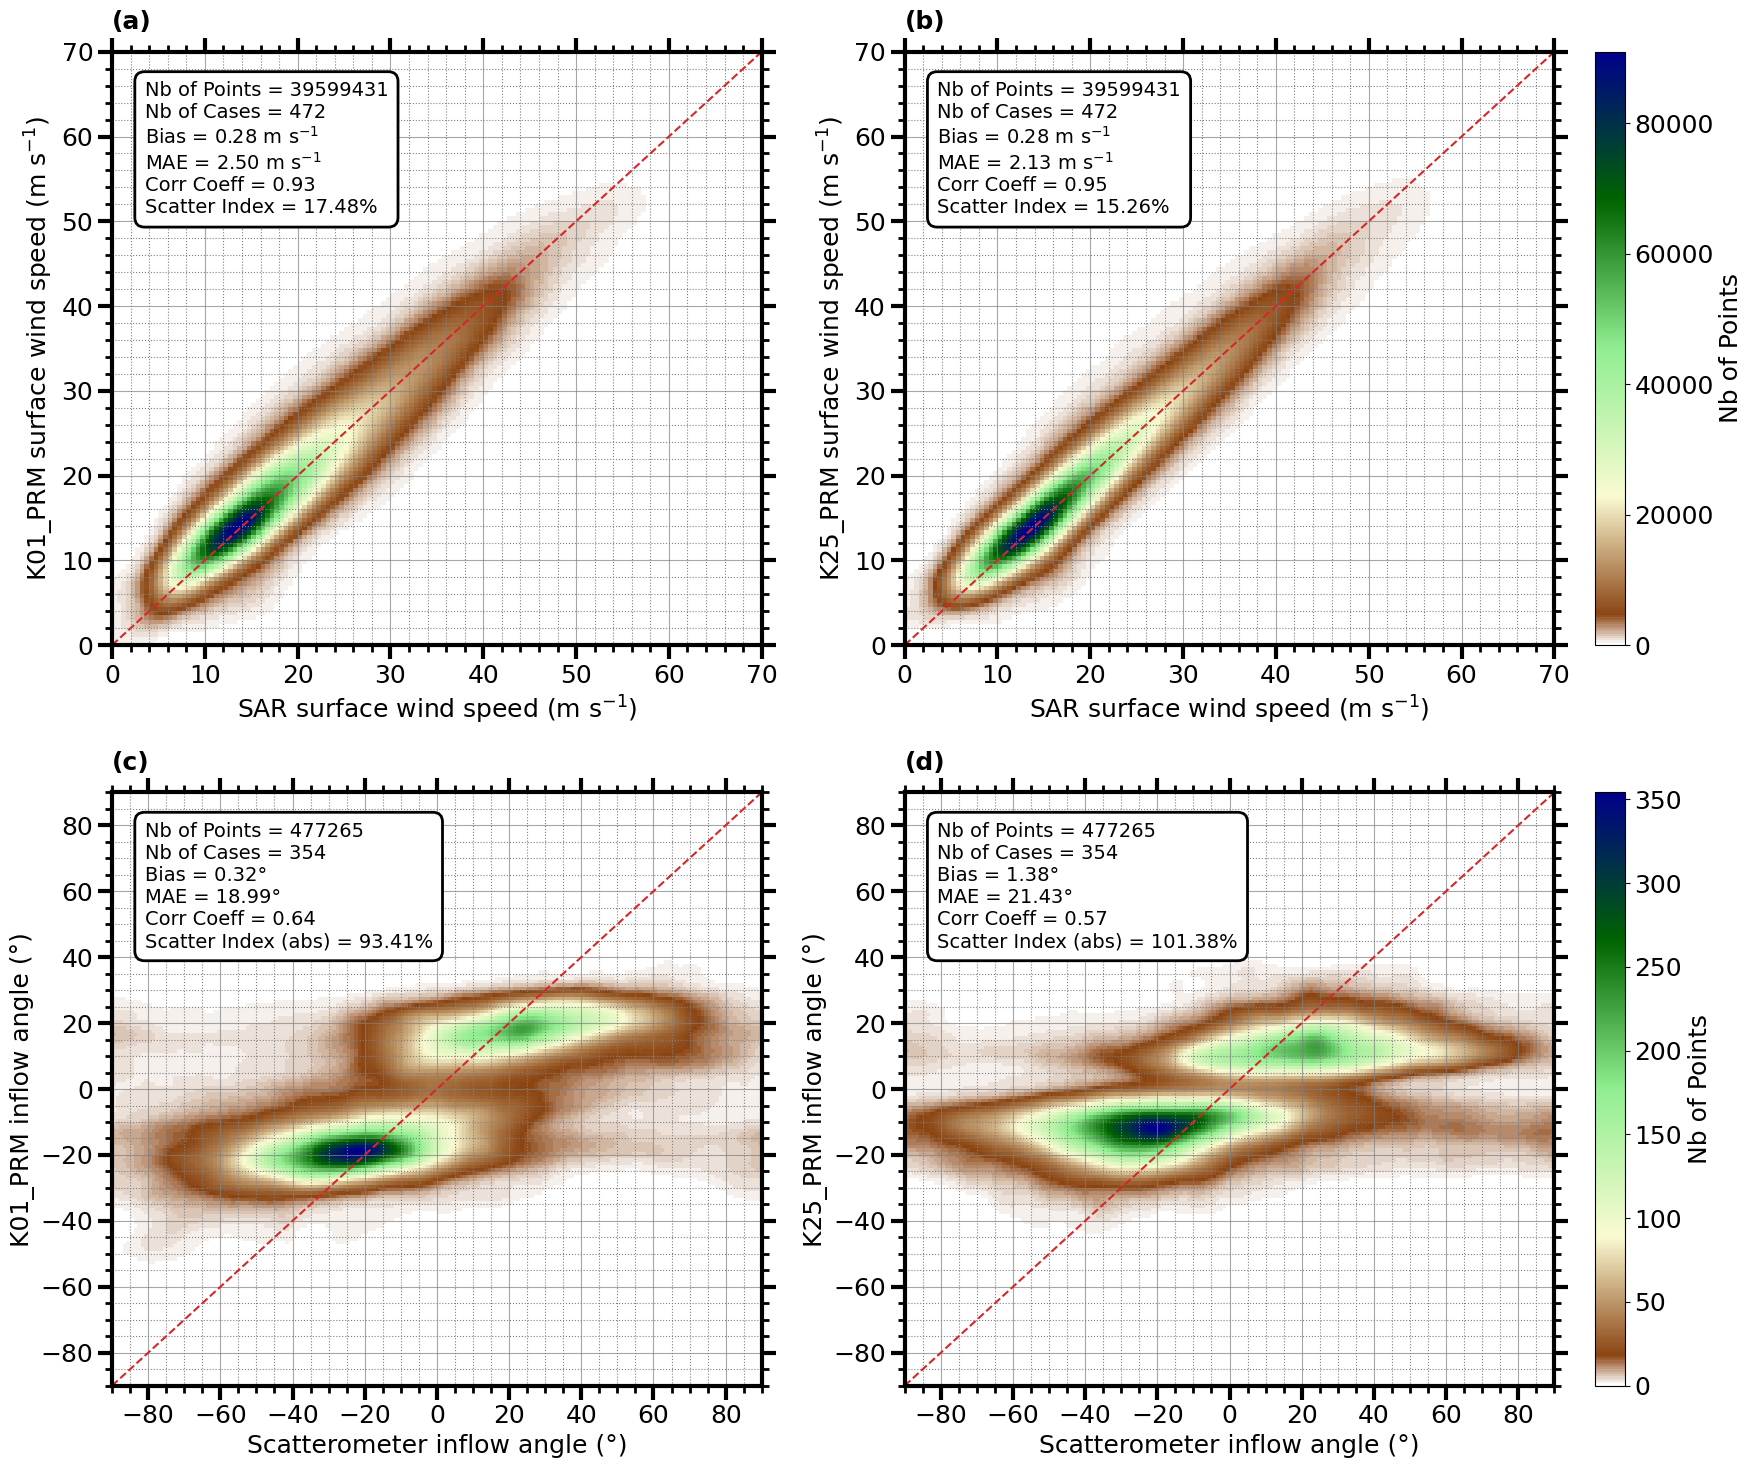

In [47]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 15))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

#####################
### K01 PRM SPEED ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01          = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk01_prm)
wspds_dsp_cleaned       = wspds_dsp[valid_mask_k01]
wspds_dsk01_prm_cleaned = wspds_dsk01_prm[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_cleaned,
    wspds_dsk01_prm_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax1.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax1.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im1, ax=ax1)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax1.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax1.set_ylabel('K01_PRM surface wind speed (m s$^{-1}$)')
ax1.set_xlim(0, 70); ax1.set_ylim(0, 70)
ax1.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk01_prm_cleaned)
n_cases       = len(listOfWspds_dsk01_prm)
differences   = wspds_dsk01_prm_cleaned - wspds_dsp_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_cleaned, wspds_dsk01_prm_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax1.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax1.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
### K25 PRM SPEED ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25          = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk25_prm)
wspds_dsp_cleaned       = wspds_dsp[valid_mask_k25]
wspds_dsk25_prm_cleaned = wspds_dsk25_prm[valid_mask_k25]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_cleaned,
    wspds_dsk25_prm_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax2.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax2.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im1, ax=ax2)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax2.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax2.set_ylabel('K25_PRM surface wind speed (m s$^{-1}$)')
ax2.set_xlim(0, 70); ax2.set_ylim(0, 70)
ax2.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk25_prm_cleaned)
n_cases       = len(listOfWspds_dsk25_prm)
differences   = wspds_dsk25_prm_cleaned - wspds_dsp_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_cleaned, wspds_dsk25_prm_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax2.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax2.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K01 PRM IA   ###
#####################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k01p = abs(ias_k01p)

# --- Nettoyage des données ---
valid_mask_k01   = ~np.isnan(ias_sct) & ~np.isnan(ias_k01p)
ias_sct_cleaned  = ias_sct[valid_mask_k01]
ias_k01p_cleaned = ias_k01p[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_cleaned,
    ias_k01p_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'Scatterometer inflow angle (°)')
ax3.set_ylabel('K01_PRM inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01p_cleaned)
n_cases       = np.shape(ias_diffs_k01p_)[0]
differences   = ias_k01p_cleaned - ias_sct_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_cleaned, ias_k01p_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 PRM IA   ###
#####################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k25p = abs(ias_k25p)

# --- Nettoyage des données ---
valid_mask_k25   = ~np.isnan(ias_sct) & ~np.isnan(ias_k25p)
ias_sct_cleaned  = ias_sct[valid_mask_k25]
ias_k25p_cleaned = ias_k25p[valid_mask_k25]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_cleaned,
    ias_k25p_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'Scatterometer inflow angle (°)')
ax4.set_ylabel('K25_PRM inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25p_cleaned)
n_cases       = np.shape(ias_diffs_k25p_)[0]
differences   = ias_k25p_cleaned - ias_sct_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_cleaned, ias_k25p_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'KXX_PRM_2D_diagnostics.png', bbox_inches='tight')

/tmp/ipykernel_33261/3083466522.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
/tmp/ipykernel_33261/3083466522.py:14: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')
/tmp/ipykernel_33261/3083466522.py:53: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
/tmp/ipykernel_33261/3083466522.py:54: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')


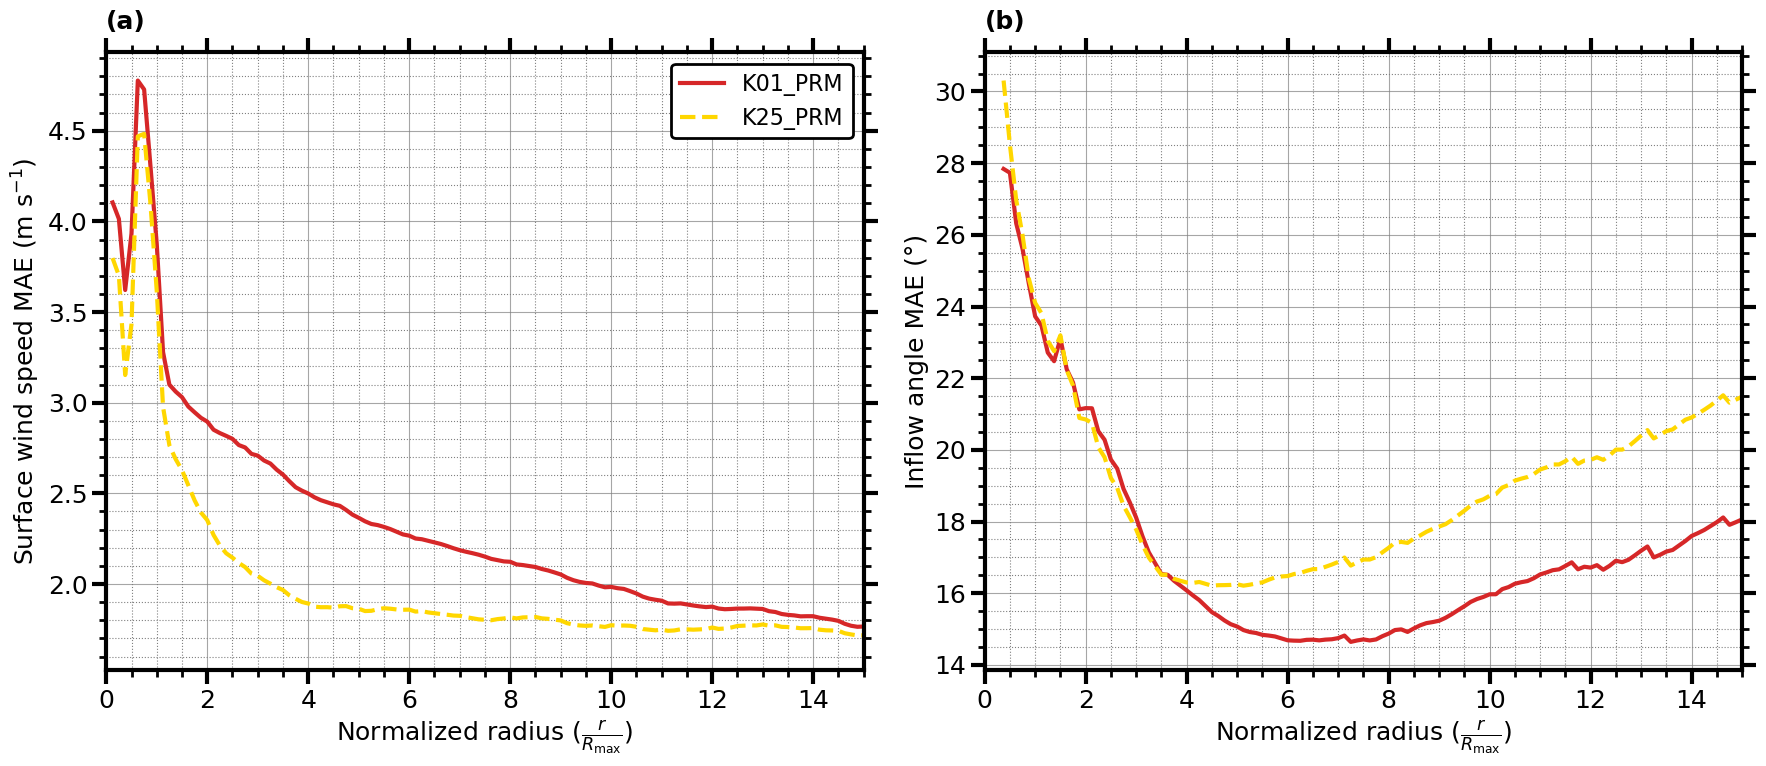

In [53]:
# Create figure with subplots
fig = plt.figure(figsize=(18, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#####################
###   MAE SPEEDS  ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Surface wind speed MAE (m s$^{-1}$)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



#####################
###  MAE INF ANG  ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')

# Labels
ax2.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax2.set_ylabel('Inflow angle MAE (°)')
ax2.set_xlim(0, 15)
ax2.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'KXX_PRM_1D_diagnostics.png', bbox_inches='tight')

#### b) KXX_FIT

In [34]:
### Define r_star
r_star = np.linspace(0, 16, 16 * 8 + 1)
# rs            = np.linspace(1000, 5e5, 500)

In [35]:
### Extract SAR and KXX_FIT wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfWspds_dsp_k01f  = [] # SAR
listOfWspds_dsp_k25f  = [] # SAR
# K01
listOfWspds_dsk01_fit = [] # K01 param
wspd_diffs_k01f       = [] # Wind speed diffs,                       
wspd_res_k01f         = [] # Wind speed relative errors
wspd_diffs_k01f_      = [] # Wind speed diffs, interp. on r_star                      
wspd_res_k01f_        = [] # Wind speed relative errors, interp. on r_star 
# K25
listOfWspds_dsk25_fit = [] # K25 param
wspd_diffs_k25f       = [] # Wind speed diffs,                       
wspd_res_k25f         = [] # Wind speed relative errors
wspd_diffs_k25f_      = [] # Wind speed diffs, interp. on r_star                       
wspd_res_k25f_        = [] # Wind speed relative errors, interp. on r_star

# K01
for file in tqdm(dk01_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk01_fit         = xr.open_dataset(PTHS['K01_FIT_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_fit.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk01_fit.file_tcva.item()).isel(time=0).interp(theta=dsk01_fit.theta)

    # Add the non-interpolated wind speeds
    wspd_diff_k01f    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk01_fit.wind_speed))
    wspd_re_k01f      = np.divide(wspd_diff_k01f, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk01f        = dsp.copy(deep=True), dsk01_fit.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01f['rad']      = dk01f['rad'] / float(ds.rmx)
    wspd_diff_k01f_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk01f.wind_speed.interp(rad=r_star)))
    wspd_re_k01f_     = np.divide(wspd_diff_k01f_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    
    ### Append
    # SAR
    listOfWspds_dsp_k01f.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K01 param
    listOfWspds_dsk01_fit.append(np.array(dsk01_fit.wind_speed).flatten())
    wspd_diffs_k01f.append(wspd_diff_k01f)
    wspd_res_k01f.append(wspd_re_k01f)
    wspd_diffs_k01f_.append(wspd_diff_k01f_)
    wspd_res_k01f_.append(wspd_re_k01f_)

    # Close
    dsp.close()
    dsk01_fit.close()
    dss.close()
    dk01f.close()

# K25
for file in tqdm(dk25_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk25_fit         = xr.open_dataset(PTHS['K25_FIT_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk25_fit.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk25_fit.file_tcva.item()).isel(time=0).interp(theta=dsk25_fit.theta)

    # Add the non-interpolated wind speeds
    wspd_diff_k25f    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk25_fit.wind_speed))
    wspd_re_k25f      = np.divide(wspd_diff_k25f, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk25f        = dsp.copy(deep=True), dsk25_fit.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk25f['rad']      = dk25f['rad'] / float(ds.rmx)
    wspd_diff_k25f_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk25f.wind_speed.interp(rad=r_star)))
    wspd_re_k25f_     = np.divide(wspd_diff_k25f_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    
    ### Append
    # SAR
    listOfWspds_dsp_k25f.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K25 param
    listOfWspds_dsk25_fit.append(np.array(dsk25_fit.wind_speed).flatten())
    wspd_diffs_k25f.append(wspd_diff_k25f)
    wspd_res_k25f.append(wspd_re_k25f)
    wspd_diffs_k25f_.append(wspd_diff_k25f_)
    wspd_res_k25f_.append(wspd_re_k25f_)

    # Close
    dsp.close()
    dsk25_fit.close()
    dss.close()
    dk25f.close()

  0%|          | 0/282 [00:00<?, ?it/s]

In [41]:
### Concatenate the raw wind speeds
wspds_dsp_k01f      = np.concatenate(listOfWspds_dsp_k01f)
wspds_dsp_k25f      = np.concatenate(listOfWspds_dsp_k25f)
wspds_dsk01_fit     = np.concatenate(listOfWspds_dsk01_fit)
wspds_dsk25_fit     = np.concatenate(listOfWspds_dsk25_fit)

### Concatenate the r_star wind speeds
arr_spd_diffs_k01f_ = np.concatenate(wspd_diffs_k01f_)
arr_spd_diffs_k25f_ = np.concatenate(wspd_diffs_k25f_)

In [50]:
### Open inflow angles

# Initialize
list_of_collocated_sct_pths_k01f = []
list_of_collocated_sar_fles_k01f = []
list_of_collocated_sct_pths_k25f = []
list_of_collocated_sar_fles_k25f = []

# K01
for t in tqdm(range(len(dk01_clean.dropna(dim='time', subset=['vmx']).time))):
    ds = dk01_clean.dropna(dim='time', subset=['vmx']).isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths_k01f.append(matching_path)
            list_of_collocated_sar_fles_k01f.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()

print(len(list_of_collocated_sct_pths_k01f))

# K25
for t in tqdm(range(len(dk25_clean.dropna(dim='time', subset=['vmx']).time))):
    ds = dk25_clean.dropna(dim='time', subset=['vmx']).isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths_k25f.append(matching_path)
            list_of_collocated_sar_fles_k25f.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()

print(len(list_of_collocated_sct_pths_k25f))

  0%|          | 0/282 [00:00<?, ?it/s]

207


  0%|          | 0/221 [00:00<?, ?it/s]

159


In [51]:
### Open data
# (about 1 minute)

# SCAT
dsc_sct_k01f = xr.open_mfdataset(list_of_collocated_sct_pths_k01f, combine='nested', concat_dim='idx')
dsc_sct_k25f = xr.open_mfdataset(list_of_collocated_sct_pths_k25f, combine='nested', concat_dim='idx')
# K01 FIT
dsk01f  = xr.open_mfdataset([PTHS['K01_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles_k01f], combine='nested', concat_dim='idx')
# K25 FIT
dsk25f  = xr.open_mfdataset([PTHS['K25_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles_k25f], combine='nested', concat_dim='idx')

In [52]:
### Flatten raw inflow angles
ias_sct_k01f = np.array(dsc_sct_k01f.inflow_angle).flatten()
ias_sct_k25f = np.array(dsc_sct_k25f.inflow_angle).flatten()
ias_k01f     = np.array(dsk01f.sel(z=10).interp(theta=dsc_sct_k01f.theta, rad=dsc_sct_k01f.rad, method='nearest').inflow_angle).flatten()
ias_k25f     = np.array(dsk25f.sel(z=10).interp(theta=dsc_sct_k25f.theta, rad=dsc_sct_k25f.rad, method='nearest').inflow_angle).flatten()

In [57]:
### Interpolate inflow angles on r_star
# (about 1 minute)

### Initialize
# K01 param
ias_diffs_k01f_ = [] # K01 fit
# K25 param
ias_diffs_k25f_ = [] # K25 fit

# K01 FIT
for i in tqdm(range(len(dsk01f.idx))):
    file_tcva    = dsk01f.isel(idx=i).file_tcva
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk01f   = dsc_sct_k01f.isel(idx=i).copy(deep=True), dsk01f.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk01f['rad'] = dk01f['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk01f.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k01f_.append(diff)
    # Close
    dss.close()
    dk01f.close()

# K25 FIT
for i in tqdm(range(len(dsk25f.idx))):
    file_tcva    = dsk25f.isel(idx=i).file_tcva
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk25f   = dsc_sct_k25f.isel(idx=i).copy(deep=True), dsk25f.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk25f['rad'] = dk25f['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk25f.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k25f_.append(diff)
    # Close
    dss.close()
    dk25f.close()

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

In [58]:
### Concatenate the r_star inflow angles
arr_ia_diffs_k01f_ = np.concatenate(ias_diffs_k01f_)
arr_ia_diffs_k25f_ = np.concatenate(ias_diffs_k25f_)

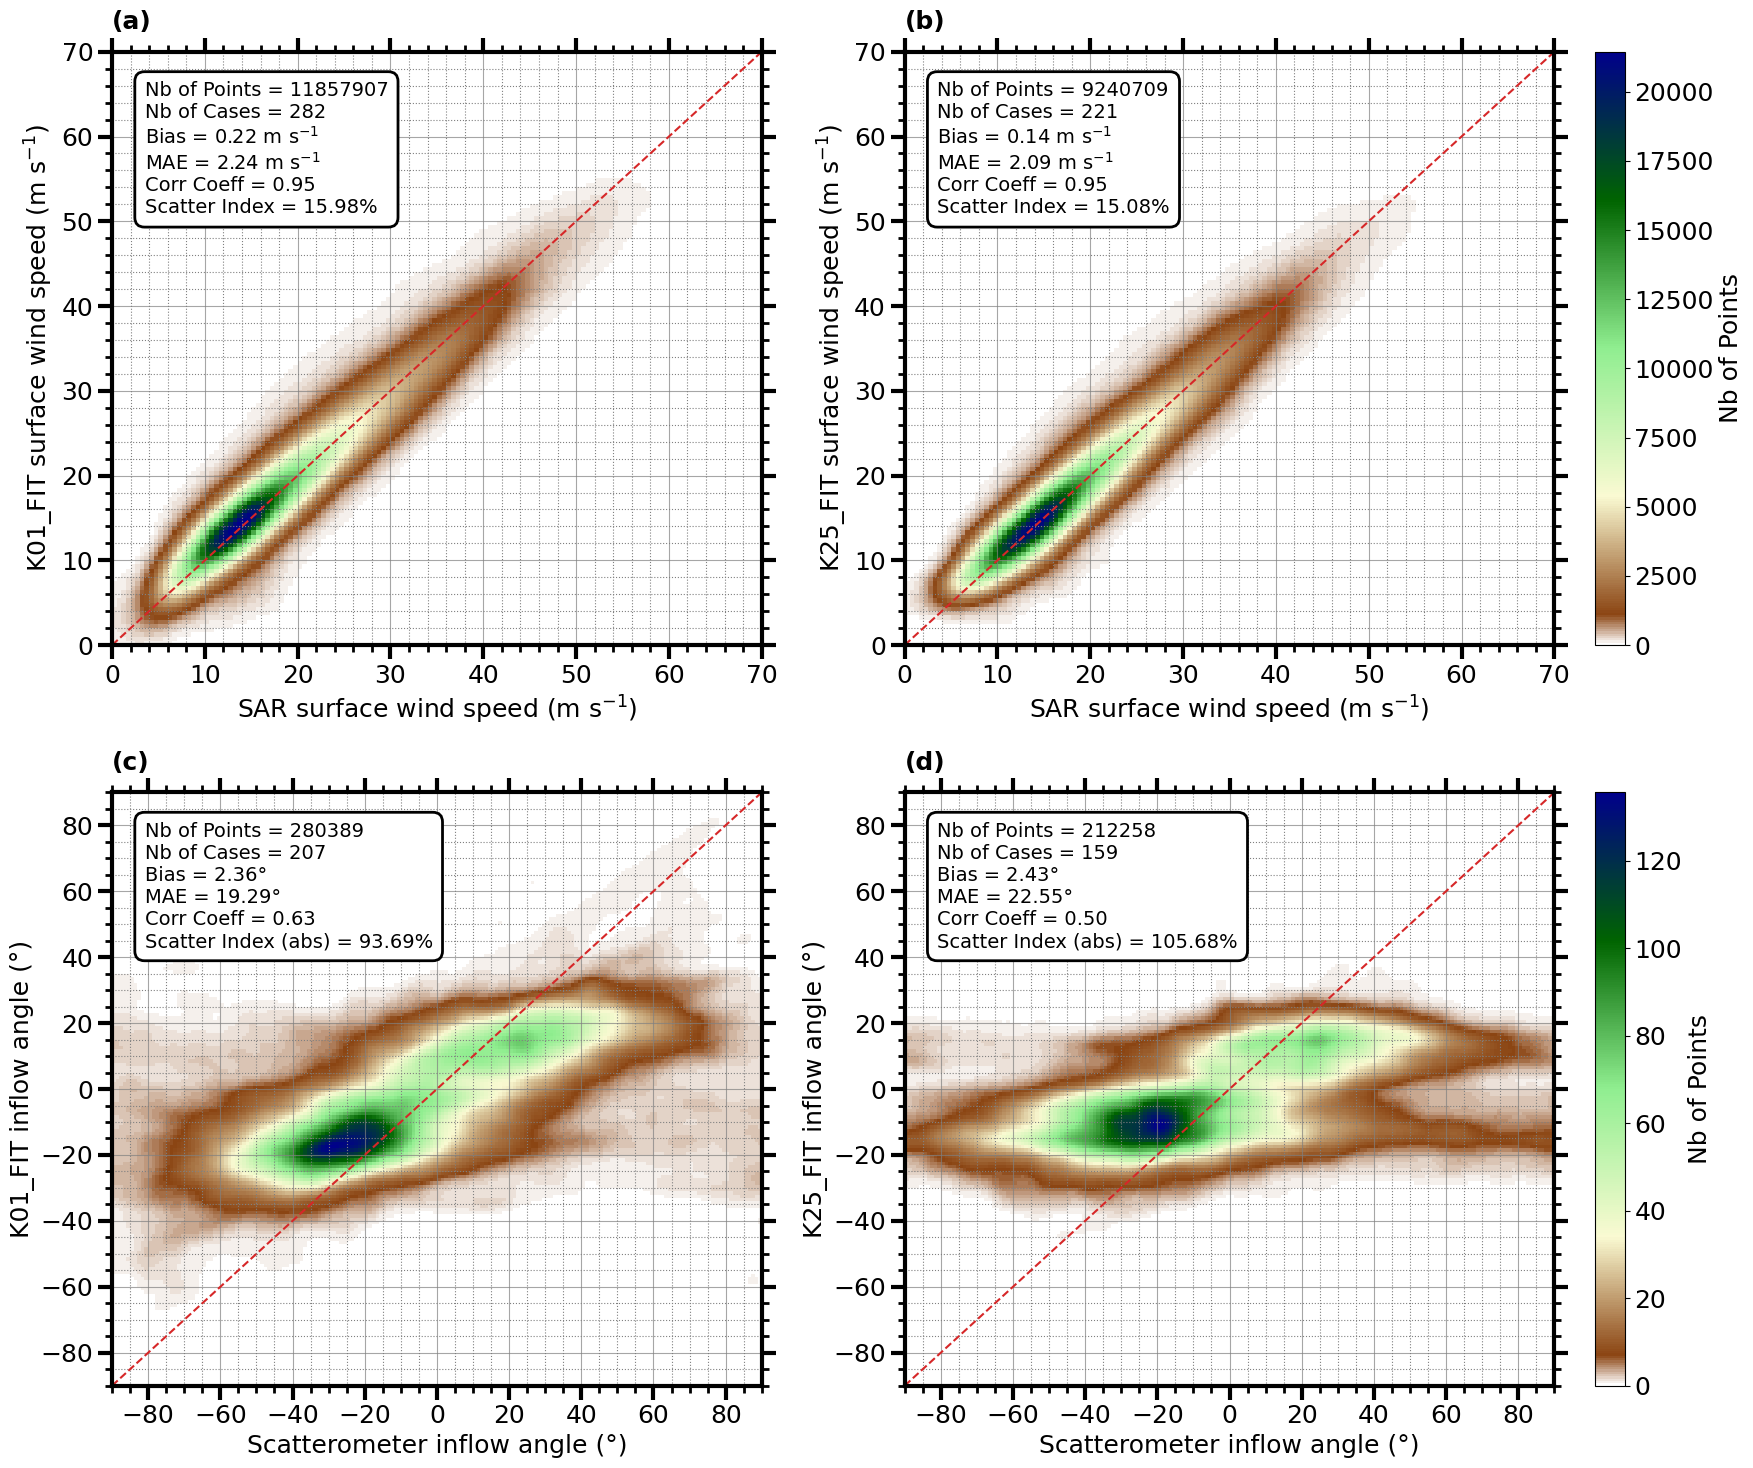

In [64]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 15))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

#####################
### K01 PRM SPEED ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01f         = ~np.isnan(wspds_dsp_k01f) & ~np.isnan(wspds_dsk01_fit)
wspds_dsp_k01f_cleaned  = wspds_dsp_k01f[valid_mask_k01f]
wspds_dsk01_fit_cleaned = wspds_dsk01_fit[valid_mask_k01f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_k01f_cleaned,
    wspds_dsk01_fit_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax1.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax1.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im1, ax=ax1)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax1.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax1.set_ylabel('K01_FIT surface wind speed (m s$^{-1}$)')
ax1.set_xlim(0, 70); ax1.set_ylim(0, 70)
ax1.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk01_fit_cleaned)
n_cases       = len(listOfWspds_dsk01_fit)
differences   = wspds_dsk01_fit_cleaned - wspds_dsp_k01f_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_k01f_cleaned, wspds_dsk01_fit_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_k01f_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax1.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax1.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
### K25 PRM SPEED ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25f         = ~np.isnan(wspds_dsp_k25f) & ~np.isnan(wspds_dsk25_fit)
wspds_dsp_k25f_cleaned  = wspds_dsp_k25f[valid_mask_k25f]
wspds_dsk25_fit_cleaned = wspds_dsk25_fit[valid_mask_k25f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_k25f_cleaned,
    wspds_dsk25_fit_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax2.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax2.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im1, ax=ax2)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax2.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax2.set_ylabel('K25_FIT surface wind speed (m s$^{-1}$)')
ax2.set_xlim(0, 70); ax2.set_ylim(0, 70)
ax2.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk25_fit_cleaned)
n_cases       = len(listOfWspds_dsk25_fit)
differences   = wspds_dsk25_fit_cleaned - wspds_dsp_k25f_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_k25f_cleaned, wspds_dsk25_fit_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_k25f_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax2.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax2.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K01 PRM IA   ###
#####################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01f      = ~np.isnan(ias_sct_k01f) & ~np.isnan(ias_k01f)
ias_sct_k01f_cleaned = ias_sct_k01f[valid_mask_k01f]
ias_k01f_cleaned     = ias_k01f[valid_mask_k01f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_k01f_cleaned,
    ias_k01f_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'Scatterometer inflow angle (°)')
ax3.set_ylabel('K01_FIT inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01f_cleaned)
n_cases       = np.shape(ias_diffs_k01f_)[0]
differences   = ias_k01f_cleaned - ias_sct_k01f_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_k01f_cleaned, ias_k01f_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_k01f_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 PRM IA   ###
#####################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25f      = ~np.isnan(ias_sct_k25f) & ~np.isnan(ias_k25f)
ias_sct_k25f_cleaned = ias_sct_k25f[valid_mask_k25f]
ias_k25f_cleaned     = ias_k25f[valid_mask_k25f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_k25f_cleaned,
    ias_k25f_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'Scatterometer inflow angle (°)')
ax4.set_ylabel('K25_FIT inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25f_cleaned)
n_cases       = np.shape(ias_diffs_k25f_)[0]
differences   = ias_k25f_cleaned - ias_sct_k25f_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_k25f_cleaned, ias_k25f_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_k25f_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'KXX_FIT_2D_diagnostics.png', bbox_inches='tight')

/tmp/ipykernel_30509/1524133792.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
/tmp/ipykernel_30509/1524133792.py:14: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')
/tmp/ipykernel_30509/1524133792.py:53: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
/tmp/ipykernel_30509/1524133792.py:54: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')


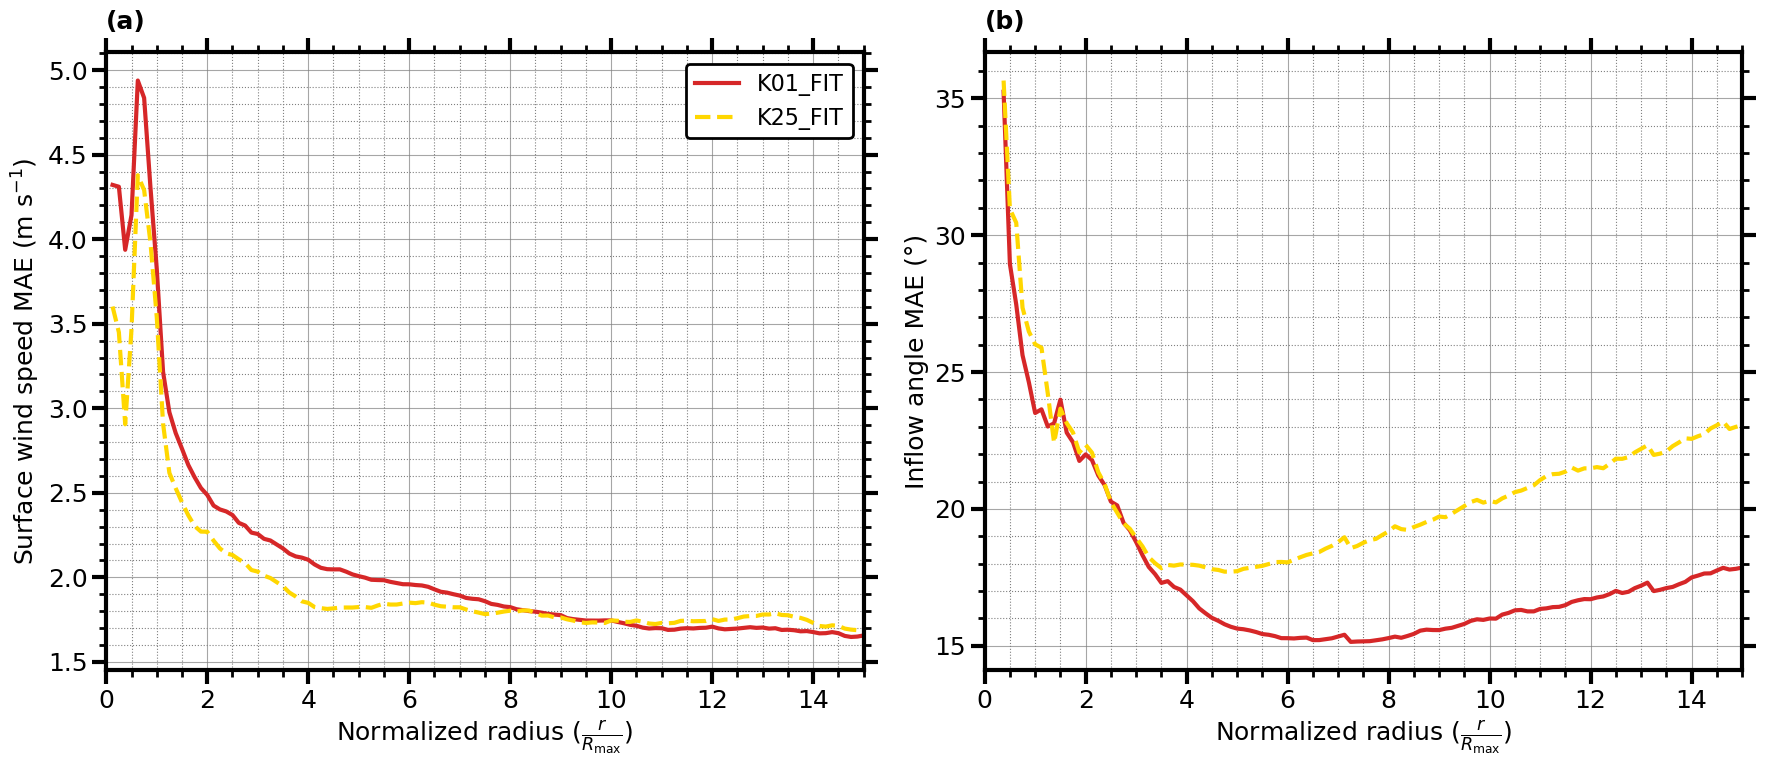

In [66]:
# Create figure with subplots
fig = plt.figure(figsize=(18, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#####################
###   MAE SPEEDS  ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Surface wind speed MAE (m s$^{-1}$)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



#####################
###  MAE INF ANG  ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')

# Labels
ax2.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax2.set_ylabel('Inflow angle MAE (°)')
ax2.set_xlim(0, 15)
ax2.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'KXX_FIT_1D_diagnostics.png', bbox_inches='tight')